# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [192]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [193]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum().sort_values(ascending=False).head(5)

balance     25
age          0
day          0
poutcome     0
previous     0
dtype: int64

### Задание 2

In [194]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [195]:
# Преобразование признака balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace('$', '').replace(' ', '').replace(',00', '.')).astype('float')
print(round(df['balance'].mean(), 3))

1529.129


### Задание 4

In [196]:
# Обработка пропусков в признаке balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [197]:
# Обработка пропусков в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown'else x)

In [198]:
print(round(df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean(), 3))

1598.883


### Задание 6

In [199]:
# Удаление выбросов признака 'balance' по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x <= lower_bound) | (x >= upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    bounds = (lower_bound, upper_bound)
    
    return outliers, cleaned, bounds


outliers, cleaned, bounds = outliers_iqr(df, 'balance')

print(f'Границы доверительного интервала по методу Тьюки: {bounds[0], bounds[1]}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


Границы доверительного интервала по методу Тьюки: (-2241.0, 4063.0)
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

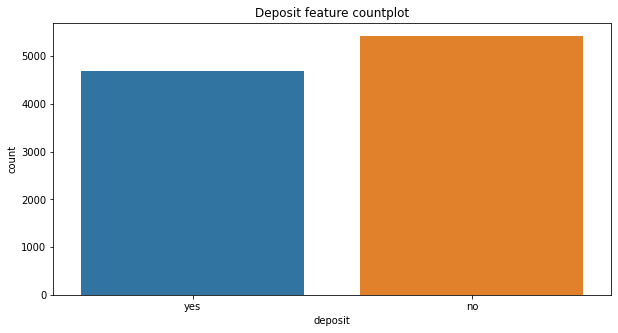

In [210]:
# Иллюстрация соотношения классов в данных на предмет несбалансированности, проиллюстрируйте результат
fig = plt.figure(figsize=(10, 5))
ax = sns.countplot(cleaned['deposit']);
ax.set_title('Deposit feature countplot')
cleaned['deposit'].value_counts()

### Задание 2

In [214]:
# Расчет описательной статистики для количественных признаков, проинтерпретируйте результат
display(cleaned.describe())

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


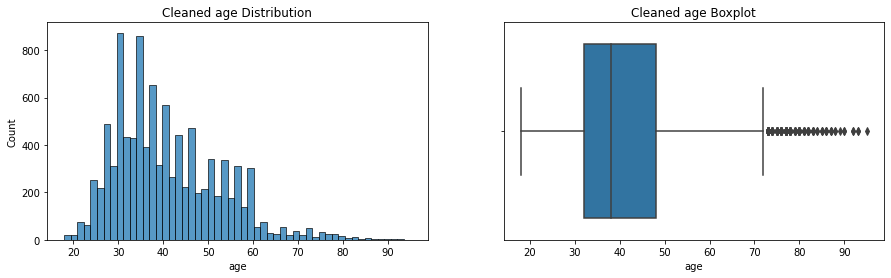

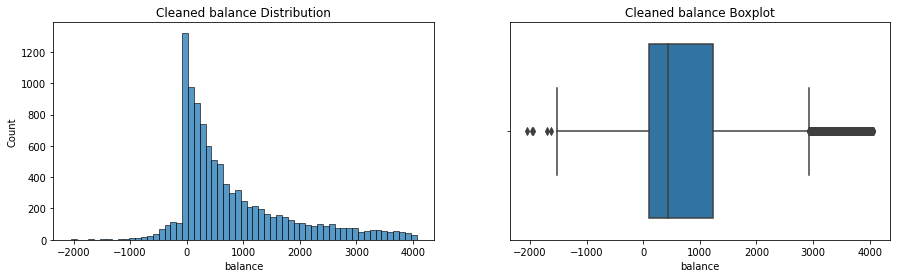

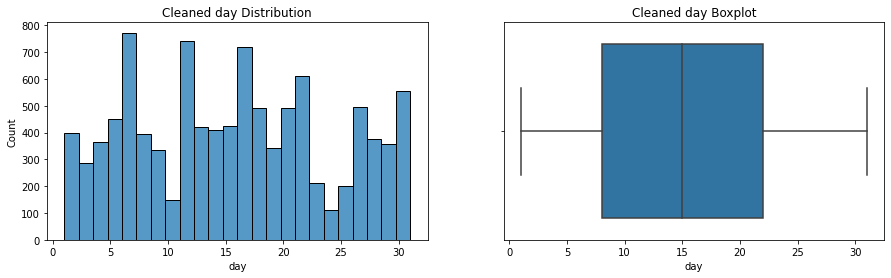

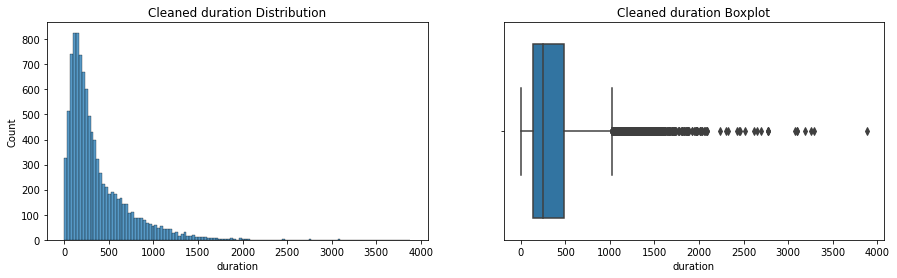

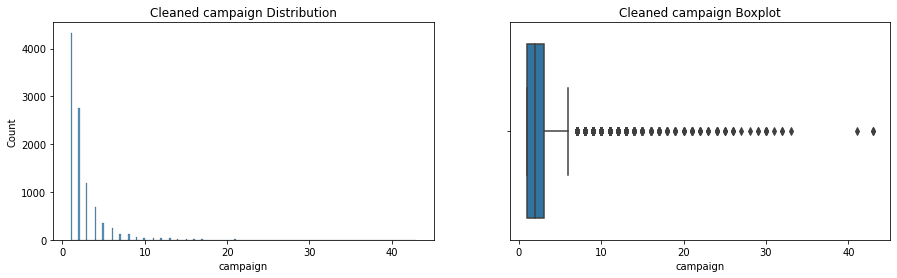

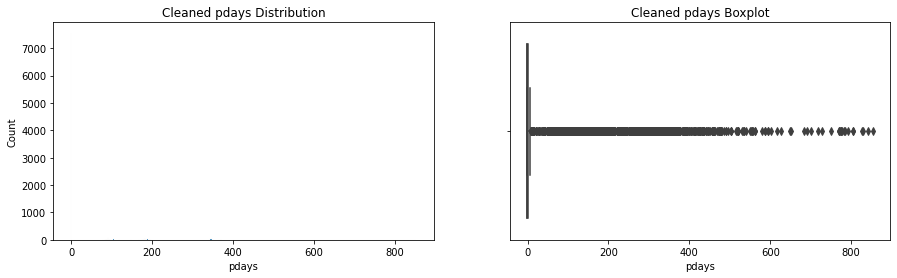

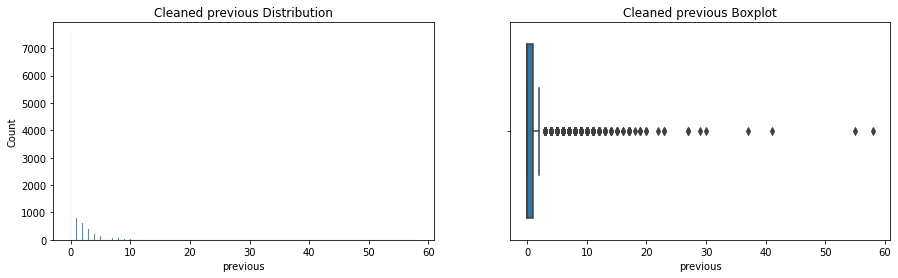

In [222]:
# Иллюстрация распределения количественных признаков
col_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

for col in col_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    histplot = sns.histplot(data=cleaned, x=col, ax=axes[0]);
    histplot.set_title(f'Cleaned {col} Distribution');
    boxplot = sns.boxplot(data=cleaned, x=col, ax=axes[1]);
    boxplot.set_title(f'Cleaned {col} Boxplot');

### Задание 3

In [221]:
# Расчет описательной статистики для категориальных признаков, проинтерпретируйте результат
cleaned.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


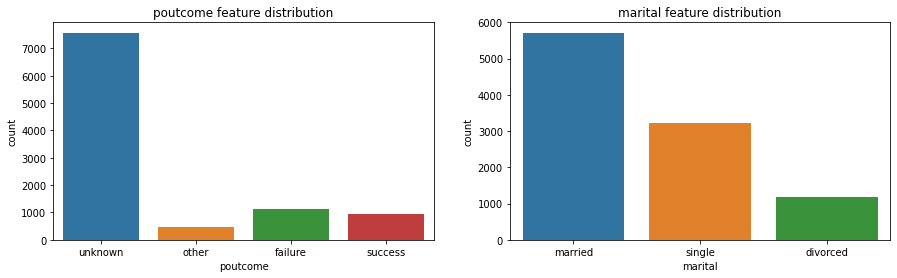

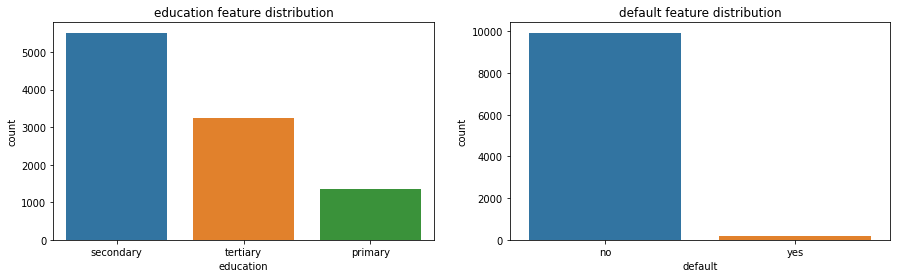

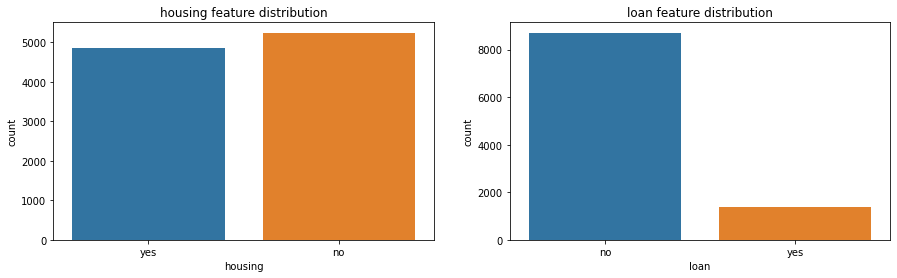

In [240]:
# Иллюстрация распределения категориальных признаков
cat_features = [['poutcome', 'marital'], ['education', 'default'], ['housing', 'loan']]

for cat in cat_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    sns.countplot(data=cleaned, x=cat[0], ax=axes[0])
    axes[0].set_title(f'{cat[0]} feature distribution');
    sns.countplot(data=cleaned, x=cat[1], ax=axes[1])
    axes[1].set_title(f'{cat[1]} feature distribution');

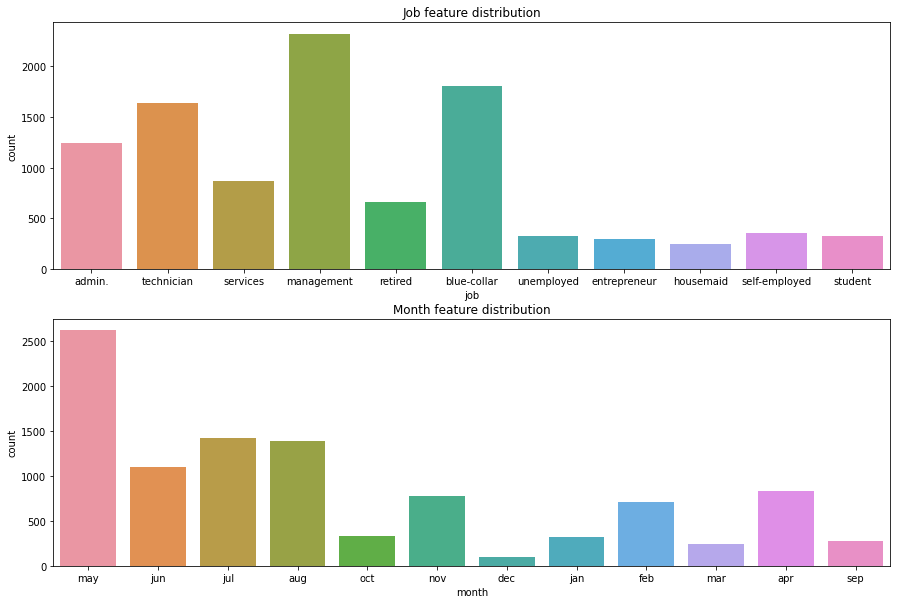

In [239]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
sns.countplot(data=cleaned, x='job', ax=axes[0]);
axes[0].set_title('Job feature distribution');
sns.countplot(data=cleaned, x='month', ax=axes[1]);
axes[1].set_title('Month feature distribution');

### Задание 4

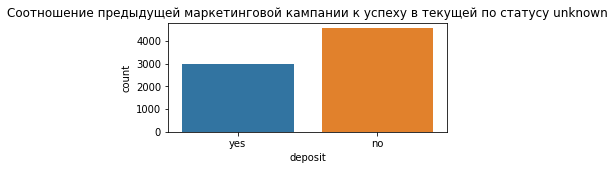

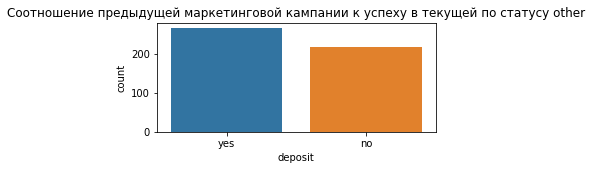

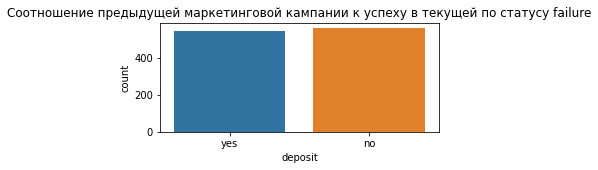

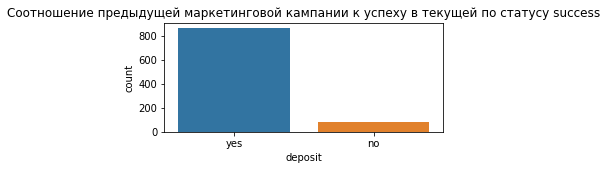

In [259]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
poutcome_list = list(cleaned['poutcome'].unique())
poutcome_list
for status in poutcome_list:
    fig = plt.figure(figsize=(5, 2))
    ax = sns.countplot(cleaned[cleaned['poutcome'] == status]['deposit'])
    ax.set_title(f'Соотношение предыдущей маркетинговой кампании к успеху в текущей по статусу {status}')

### Задание 5

In [289]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
month_list = list(cleaned['month'].unique())

month_stat = {}
for month in month_list:
    month_stat.update(
        {month: 
        round(cleaned[(cleaned['month'] == month) & (cleaned['deposit'] == 'no')].shape[0] / cleaned[cleaned['month'] == month].shape[0], 2)        
        }
)

month_stat

{'may': 0.68,
 'jun': 0.55,
 'jul': 0.59,
 'aug': 0.56,
 'oct': 0.19,
 'nov': 0.58,
 'dec': 0.1,
 'jan': 0.61,
 'feb': 0.46,
 'mar': 0.1,
 'apr': 0.38,
 'sep': 0.17}

### Задание 6

In [309]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_groupping(age):
    if age < 30:
        return '<30'
    elif (age >= 30 and age < 40):
        return '30-40'
    elif (age >= 40 and age < 50):
        return '40-50'
    elif (age >= 50 and age < 60):
        return '50-60'
    else:
        return '60+'

cleaned['age_group'] = cleaned['age'].apply(age_groupping)
cleaned['deposit_'] = cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
age_grouped = cleaned.groupby(['age_group'])['deposit_'].mean()
display(age_grouped)
marital_grouped = cleaned.groupby(['marital'])['deposit_'].mean()
display(marital_grouped)
education_grouped = cleaned.groupby(['education'])['deposit_'].mean()
display(education_grouped)

age_group
30-40    0.433224
40-50    0.393787
50-60    0.405079
60+      0.759571
<30      0.591753
Name: deposit_, dtype: float64

marital
divorced    0.469839
married     0.422047
single      0.534080
Name: deposit_, dtype: float64

education
primary      0.383247
secondary    0.444263
tertiary     0.528867
Name: deposit_, dtype: float64

### Задание 7

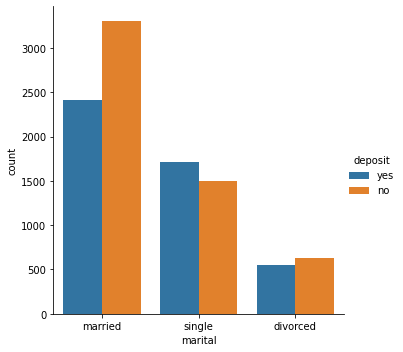

In [352]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
catplot = sns.catplot(
    data=cleaned,
    x='marital',
    hue='deposit',
    kind='count'
);


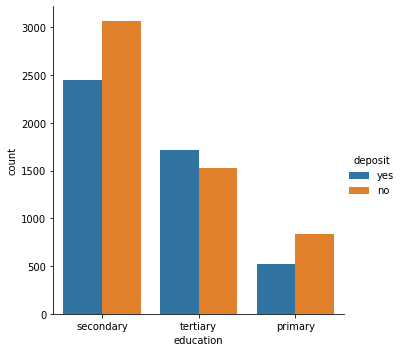

In [353]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
catplot = sns.catplot(
    data=cleaned,
    x='education',
    hue='deposit',
    kind='count'
);


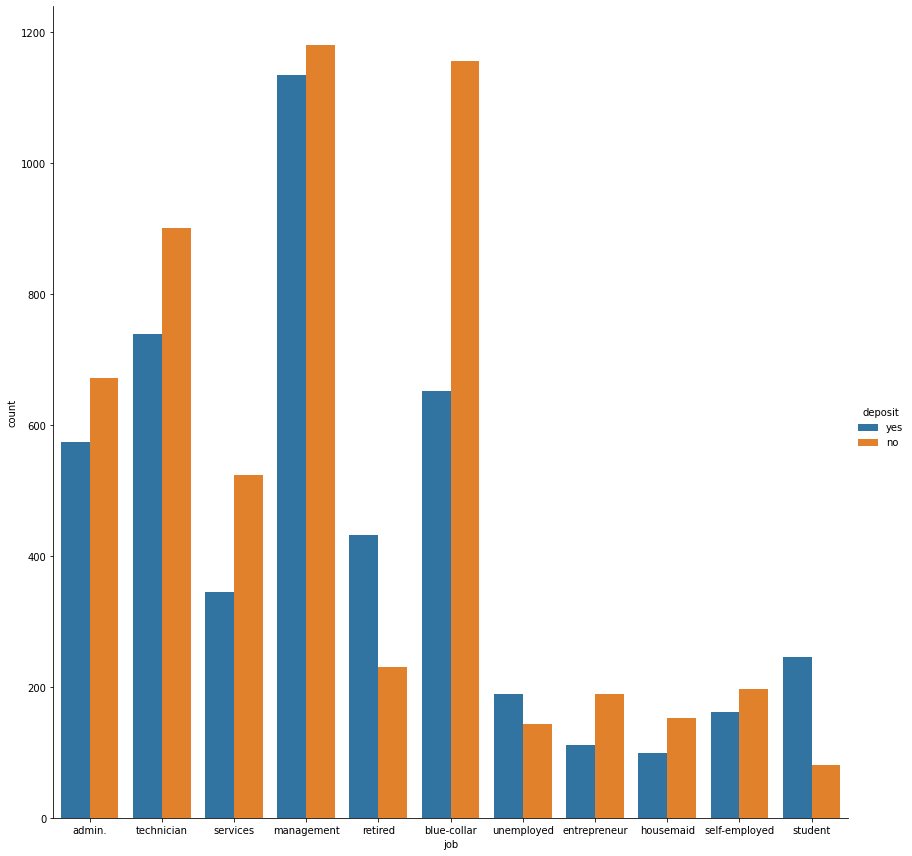

In [359]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
catplot = sns.catplot(
    data=cleaned,
    x='job',
    hue='deposit',
    kind='count',
    height=12,
    aspect=1
);


### Задание 8

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


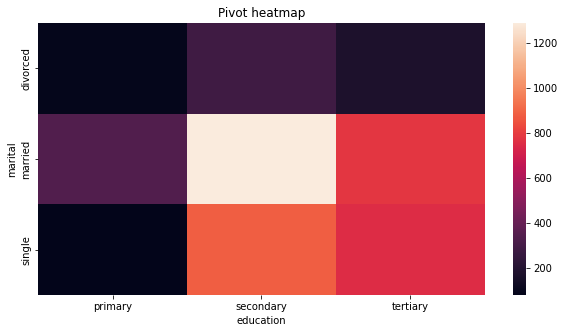

In [368]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
positive = cleaned[cleaned['deposit'] == 'yes']
negative = cleaned[cleaned['deposit'] == 'no']

pivot_pos = pd.pivot_table(positive, values='deposit', index=['marital'],
                    columns=['education'], aggfunc=np.count_nonzero)

display(pivot_pos)

fig = plt.figure(figsize=(10, 5))
hm = sns.heatmap(pivot_pos);
hm.set_title('Pivot heatmap');

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задание 2

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 3

In [ ]:
# создайте дамми-переменные

### Задание 4

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задание 5

In [3]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 6

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 7

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задание 2

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 3

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задание 2

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание3

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 4

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задание 5

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna